Données chargées et standardisées.
Démarrage de la Cross-Validation 5-fold...
--- Fold 1/5 ---
Accuracy du Fold 1: 0.9462
--- Fold 2/5 ---
Accuracy du Fold 2: 0.9503
--- Fold 3/5 ---
Accuracy du Fold 3: 0.9463
--- Fold 4/5 ---
Accuracy du Fold 4: 0.9499
--- Fold 5/5 ---
Accuracy du Fold 5: 0.9460

--- RÉSULTATS FINAUX DE LA CROSS-VALIDATION ---
Accuracy Moyenne sur 5 folds: 94.77%
Écart-type de l'Accuracy: 0.0019


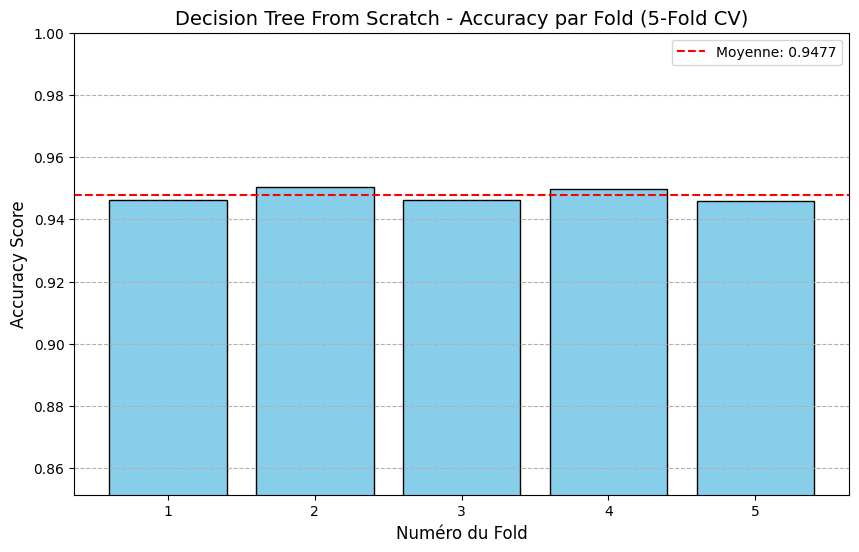


Graphique sauvegardé dans : C:\Users\hp\Desktop\TPs\DataMining\Results\plots_dt\dt_cross_validation_accuracy.png


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt # <-- Importation pour le plotting
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
from collections import Counter
import warnings

# --- CONFIGURATION ---
CHEMIN_FICHIER = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\preparing\\Final_Reduit30_70.csv'
COLONNE_CIBLE = 'classe'
DOSSIER_PLOTS = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\Results\\plots_dt' # Nouveau dossier pour les plots DT

# Créer le dossier des plots s'il n'existe pas
if not os.path.exists(DOSSIER_PLOTS):
    os.makedirs(DOSSIER_PLOTS)

# Supprimer les warnings
warnings.filterwarnings('ignore') 

# --- STRUCTURE DE DONNÉES DE L'ARBRE (Node) ---
class Node:
    """Représente un nœud dans l'arbre de décision."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# --- CLASSE : DECISION TREE CLASSIFIER FROM SCRATCH ---
class DecisionTreeClassifierFromScratch:
    # ... (les méthodes _gini, _best_split, _build_tree, fit, _traverse_tree, predict sont identiques) ...
    
    def __init__(self, max_depth=10, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _gini(self, y):
        if len(y) == 0:
            return 0
        counts = Counter(y)
        impurity = 1.0
        n_total = len(y)
        for label in counts:
            prob_of_label = counts[label] / n_total
            impurity -= prob_of_label ** 2
        return impurity

    def _best_split(self, X, y):
        best_gain = -1.0
        best_feature_index = None
        best_threshold = None
        n_features = X.shape[1]
        n_total = len(y)
        parent_gini = self._gini(y)

        for feature_index in range(n_features):
            X_column = X[:, feature_index]
            unique_thresholds = np.unique(X_column)
            
            for threshold in unique_thresholds:
                left_mask = X_column <= threshold
                y_left = y[left_mask]
                y_right = y[~left_mask]

                n_left, n_right = len(y_left), len(y_right)
                if n_left == 0 or n_right == 0:
                    continue

                gini_left = self._gini(y_left)
                gini_right = self._gini(y_right)
                
                weighted_gini = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right
                gain = parent_gini - weighted_gini
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold
                    
        return best_feature_index, best_threshold

    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or 
            n_labels == 1 or 
            n_samples < self.min_samples_split):
            
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        feature_index, threshold = self._best_split(X, y)
        
        if feature_index is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        X_column = X[:, feature_index]
        left_mask = X_column <= threshold
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[~left_mask], y[~left_mask]

        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        return Node(feature_index, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        
        feature_value = x[node.feature_index]
        if feature_value <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

# --- FONCTION DE CROSS-VALIDATION (Mise à jour pour retourner les scores) ---
def cross_validate_dt(X, y, n_splits=5, max_depth=15, min_samples_split=20):
    """
    Effectue la Cross-Validation k-fold et retourne les scores d'Accuracy par fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_scores = []
    
    print(f"Démarrage de la Cross-Validation {n_splits}-fold...")
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1}/{n_splits} ---")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = DecisionTreeClassifierFromScratch(
            max_depth=max_depth, 
            min_samples_split=min_samples_split
        )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        accuracy_scores.append(acc)
        print(f"Accuracy du Fold {fold + 1}: {acc:.4f}")
        
    return accuracy_scores

# --- FONCTION DE PLOTTING ---
def plot_cv_results(scores, n_splits, save_path):
    """
    Génère un graphique à barres des scores d'Accuracy obtenus à chaque fold.
    
    """
    
    mean_accuracy = np.mean(scores)
    
    # Création du plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_splits + 1), scores, color='skyblue', edgecolor='k')
    
    # Ligne de la moyenne
    plt.axhline(mean_accuracy, color='red', linestyle='--', label=f'Moyenne: {mean_accuracy:.4f}')
    
    # Labels et Titres
    plt.title(f'Decision Tree From Scratch - Accuracy par Fold ({n_splits}-Fold CV)', fontsize=14)
    plt.xlabel('Numéro du Fold', fontsize=12)
    plt.ylabel('Accuracy Score', fontsize=12)
    plt.xticks(range(1, n_splits + 1))
    plt.ylim(min(scores) * 0.9, 1.0) # Ajuster l'axe Y pour une meilleure visualisation
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    
    # Sauvegarde
    plt.savefig(save_path)
    plt.show()
    print(f"\nGraphique sauvegardé dans : {save_path}")


# --- PRÉPARATION ET EXÉCUTION ---

# --- Chargement et préparation des données ---
try:
    df = pd.read_csv(CHEMIN_FICHIER)
except FileNotFoundError:
    print(f"Erreur: Le fichier {CHEMIN_FICHIER} n'a pas été trouvé.")
    exit()

X = df.drop(columns=[COLONNE_CIBLE, 'latitude', 'longitude'], errors='ignore').values
y = df[COLONNE_CIBLE].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Données chargées et standardisées.")

# --- EXÉCUTION DE LA CROSS-VALIDATION ---
N_FOLDS = 5
MAX_DEPTH = 15
MIN_SAMPLES_SPLIT = 20

all_scores = cross_validate_dt(
    X=X_scaled, 
    y=y, 
    n_splits=N_FOLDS, 
    max_depth=MAX_DEPTH, 
    min_samples_split=MIN_SAMPLES_SPLIT
)

# --- Affichage et sauvegarde des résultats ---
mean_acc = np.mean(all_scores)
std_acc = np.std(all_scores)

print("\n--- RÉSULTATS FINAUX DE LA CROSS-VALIDATION ---")
print(f"Accuracy Moyenne sur {N_FOLDS} folds: {mean_acc*100:.2f}%")
print(f"Écart-type de l'Accuracy: {std_acc:.4f}")

# Plotting
plot_path = os.path.join(DOSSIER_PLOTS, 'dt_cross_validation_accuracy.png')
plot_cv_results(all_scores, N_FOLDS, plot_path)